In [1]:
%autosave 0

Autosave disabled


# Analysis of Bicycle Sharing at Seattle 
##### by Chenglong Song

   Nowadays, bicycle-sharing systems are growing in number and scale worldwide as a popular mode of public transportation. While keeping pace with the rhythm of big cities, it meets the needs of most residents. The public bicycle sharing system allows users to rent bicycles for short-distance, and the users can easily access the system to unlock or return the bicycles. The technologies provide a large amount of data that can be used to explore the systems. 

   In this project, I use the cycle share dataset from Kaggle as the resource. The dataset introduces the Pronto bicycle sharing system, which consists of 500 bicycles and 54 stations in Seattle. Pronto provides three data sets on personal travel, stations, and daily weather in 2014-2016. This project includes the analysis of the cycle share dataset by using python and discusses how bike uses are affected by user characteristics, time, and weather factors.
   
   This is the link to my [GitHub repository](https://github.com/jakie0317/DSCI-235).
   
   This is the link to the resource [Kaggle](https://www.kaggle.com/pronto/cycle-share-dataset).


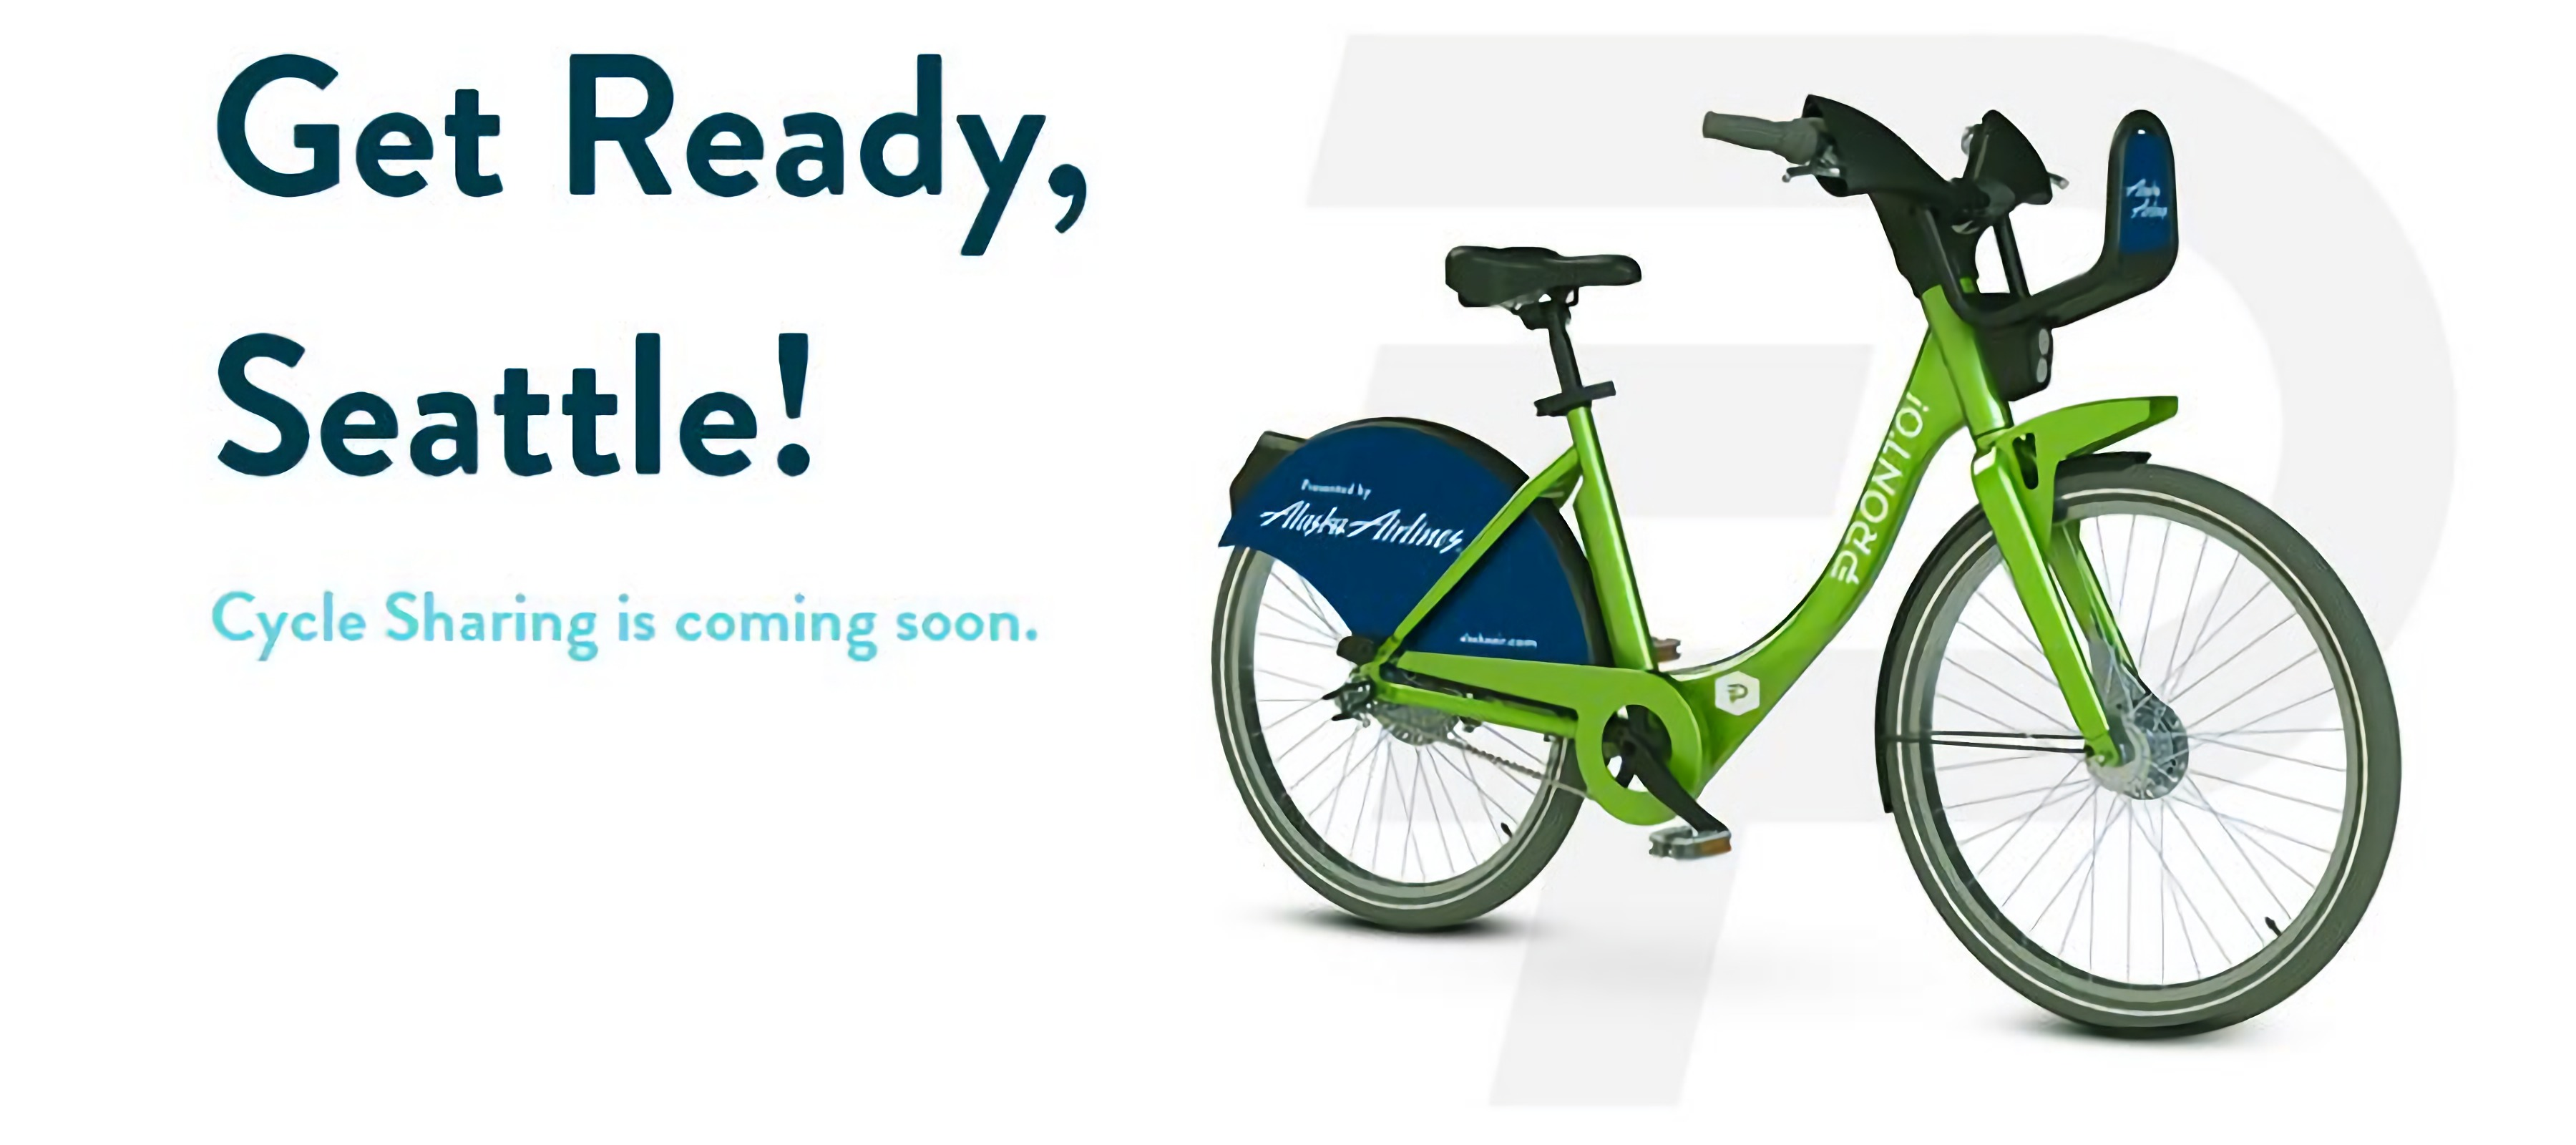

## Part 1: Data acquisition


First, we need to import libraries and the datasets.

In [2]:
# Importing libraries
import pandas as pd   
import numpy as np
import datetime     
import matplotlib.pyplot as plt      
%matplotlib inline
plt.style.use('ggplot') 
import warnings         
warnings.filterwarnings('ignore') 

In [3]:
# Importing the datasets
trip=pd.read_csv('~/DSCI 235/trip.csv',error_bad_lines=False,warn_bad_lines=False)
weather=pd.read_csv('~/DSCI 235/weather.csv')

Then let's take an overview of the data sets, then check the field data types and missing values. If there are missing values, the missing values should be dealt with later and then analyzed.

In [4]:
trip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286857 entries, 0 to 286856
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   trip_id            286857 non-null  int64  
 1   starttime          286857 non-null  object 
 2   stoptime           286857 non-null  object 
 3   bikeid             286857 non-null  object 
 4   tripduration       286857 non-null  float64
 5   from_station_name  286857 non-null  object 
 6   to_station_name    286857 non-null  object 
 7   from_station_id    286857 non-null  object 
 8   to_station_id      286857 non-null  object 
 9   usertype           286857 non-null  object 
 10  gender             181557 non-null  object 
 11  birthyear          181553 non-null  float64
dtypes: float64(2), int64(1), object(9)
memory usage: 26.3+ MB


In [5]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        689 non-null    object 
 1   Max_Temperature_F           689 non-null    int64  
 2   Mean_Temperature_F          688 non-null    float64
 3   Min_TemperatureF            689 non-null    int64  
 4   Max_Dew_Point_F             689 non-null    int64  
 5   MeanDew_Point_F             689 non-null    int64  
 6   Min_Dewpoint_F              689 non-null    int64  
 7   Max_Humidity                689 non-null    int64  
 8   Mean_Humidity               689 non-null    int64  
 9   Min_Humidity                689 non-null    int64  
 10  Max_Sea_Level_Pressure_In   689 non-null    float64
 11  Mean_Sea_Level_Pressure_In  689 non-null    float64
 12  Min_Sea_Level_Pressure_In   689 non-null    float64
 13  Max_Visibility_Miles        689 non

## Part 2: Data cleaning


After go over the data sets, we need to delete redundant fields and renamed the fields to speed up data processing and increase data readability.

In [6]:
trip.drop(['tripduration','from_station_name','to_station_name','from_station_id','to_station_id','gender'],axis=1,inplace=True)
trip.rename(columns={'starttime':'start_time','stoptime':'stop_time','bikeid':'bike_id',
                     'usertype':'user_type','birthyear':'birth_year'},inplace=True)
trip.head()

,trip_id,start_time,stop_time,bike_id,user_type,birth_year
0,431,10/13/2014 10:31,10/13/2014 10:48,SEA00298,Member,1960.0
1,432,10/13/2014 10:32,10/13/2014 10:48,SEA00195,Member,1970.0
2,433,10/13/2014 10:33,10/13/2014 10:48,SEA00486,Member,1988.0
3,434,10/13/2014 10:34,10/13/2014 10:48,SEA00333,Member,1977.0
4,435,10/13/2014 10:34,10/13/2014 10:49,SEA00202,Member,1971.0


In [7]:
weather.drop(['Max_Temperature_F','Min_TemperatureF','Max_Dew_Point_F','MeanDew_Point_F','Min_Dewpoint_F',
              'Max_Humidity','Min_Humidity','Mean_Sea_Level_Pressure_In','Max_Sea_Level_Pressure_In',
              'Min_Sea_Level_Pressure_In','Max_Visibility_Miles','Min_Visibility_Miles','Max_Wind_Speed_MPH',
              'Max_Gust_Speed_MPH','Events'],axis=1,inplace=True)

weather.rename(columns={'Mean_Temperature_F':'temperature','Mean_Humidity':'humidity',
                        'Mean_Visibility_Miles':'visibility_miles','Mean_Wind_Speed_MPH':'wind_speed',
                        'Precipitation_In':'precipitation'},inplace = True)
weather.head()

,Date,temperature,humidity,visibility_miles,wind_speed,precipitation
0,10/13/2014,62.0,68,10,4,0.00
1,10/14/2014,59.0,78,9,5,0.11
2,10/15/2014,58.0,77,9,7,0.45
3,10/16/2014,61.0,61,10,4,0.00
4,10/17/2014,60.0,72,10,3,0.14


Since the 'Date' in the weather dataset is stored as object type, and the 'start_time' and 'stop_time' in the trip dataset are both object types, we should convert them to time series to facilitate the extraction of year, month, day, and hour.

In [8]:
# Transforming the columns
trip['start_time']=pd.to_datetime(trip.start_time)
trip['stop_time']=pd.to_datetime(trip.stop_time)
weather['Date']=pd.to_datetime(weather.Date)

In [9]:
# Adding a column of date for the trip
trip['date']=trip.start_time.astype('datetime64[D]')

In [10]:
# Creating new field columns for the trip
trip['year']=trip.date.apply(lambda x: x.year)
trip['month']=trip.date.apply(lambda x: x.month)
trip['day']=trip.date.apply(lambda x: x.day)
trip['hour']=trip.start_time.apply(lambda x: x.hour)
trip['weekday']=trip.start_time.apply(lambda x: x.weekday())

Since we need to stratify the age of users, we should delete the rows with null values, and change the type of birth_year to int.

In [11]:
# Dropping NaN and Converting to integer
age=trip.dropna()
age['birth_year']=age.birth_year.astype('int64')
age.head()

,trip_id,start_time,stop_time,bike_id,user_type,birth_year,date,year,month,day,hour,weekday
0,431,2014-10-13 10:31:00,2014-10-13 10:48:00,SEA00298,Member,1960,2014-10-13,2014,10,13,10,0
1,432,2014-10-13 10:32:00,2014-10-13 10:48:00,SEA00195,Member,1970,2014-10-13,2014,10,13,10,0
2,433,2014-10-13 10:33:00,2014-10-13 10:48:00,SEA00486,Member,1988,2014-10-13,2014,10,13,10,0
3,434,2014-10-13 10:34:00,2014-10-13 10:48:00,SEA00333,Member,1977,2014-10-13,2014,10,13,10,0
4,435,2014-10-13 10:34:00,2014-10-13 10:49:00,SEA00202,Member,1971,2014-10-13,2014,10,13,10,0


#### Let's stratify the age of users by creating a function, and add age as a new field column.

In [12]:
# Creating a function for age
def agef(x):
    if 2000>x>=1995:
        return '16-21'
    elif 1995>x>=1985:
        return '21-31'
    elif 1985>x>=1975:
        return '31-41'
    elif 1975>x>=1965:
        return '41-51'
    elif 1965>x>=1956:
        return '51-60'
    elif 1956>x:
        return 'over 60'
age['age']=age.birth_year.apply(agef)
age.head()

,trip_id,start_time,stop_time,bike_id,user_type,birth_year,date,year,month,day,hour,weekday,age
0,431,2014-10-13 10:31:00,2014-10-13 10:48:00,SEA00298,Member,1960,2014-10-13,2014,10,13,10,0,51-60
1,432,2014-10-13 10:32:00,2014-10-13 10:48:00,SEA00195,Member,1970,2014-10-13,2014,10,13,10,0,41-51
2,433,2014-10-13 10:33:00,2014-10-13 10:48:00,SEA00486,Member,1988,2014-10-13,2014,10,13,10,0,21-31
3,434,2014-10-13 10:34:00,2014-10-13 10:48:00,SEA00333,Member,1977,2014-10-13,2014,10,13,10,0,31-41
4,435,2014-10-13 10:34:00,2014-10-13 10:49:00,SEA00202,Member,1971,2014-10-13,2014,10,13,10,0,41-51


## Part 3: Exploratory analysis

In this part, we are going to analyze the Pronto Bicycle-sharing in Seattle between 2014 and 2016 from three aspects which are user characteristics, time, and weather. 


#### Problem:

User Characteristics: What is the user group of the bicycle sharing system? How is the age group of the user group distributed?

Time: What is the monthly bicycle sharing system usage? What is the relationship between the average hourly usage of bicycle sharing system and weekdays?

Weather: How do temperature, humidity, visibility, wind speed, and precipitation affect the bicycle sharing system usage?


### 1. User Characteristics

Figure 1 shows the proportion of Pronto Bicycle-sharing user type between 2014 and 2016.

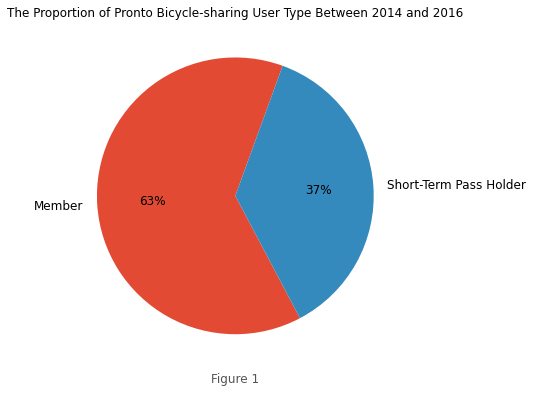

In [13]:
# The Proportion of Pronto Bicycle-sharing User Type Between 2014 and 2016
import pylab
plt.subplots(figsize=(17,14))
ax_1=plt.subplot2grid((2,2),(0,0))
df_1=trip.groupby(by=['user_type']).user_type.count()
df_1.plot.pie(startangle=70,autopct='%.f%%',ax=ax_1,textprops={'fontsize':12})
ax_1.set_title('The Proportion of Pronto Bicycle-sharing User Type Between 2014 and 2016',fontsize=12)
pylab.ylabel('')
ax_1.set_xlabel('Figure 1',fontsize=12);

Figure 2 shows the proportion of Pronto Bicycle-sharing user by age group between 2014 and 2016.

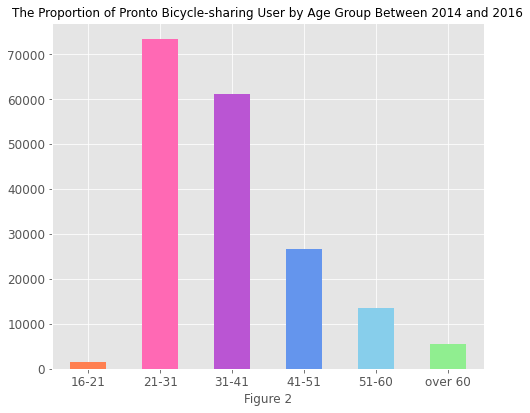

In [14]:
# The Proportion of Pronto Bicycle-sharing User by Age Group Between 2014 and 2016
plt.subplots(figsize=(17,14))
ax_2=plt.subplot2grid((2,2),(0,0))
df_2=age.groupby(by=['age']).age.count()
df_2.plot.bar(ax=ax_2,fontsize=12,color=['coral','hotpink','mediumorchid','cornflowerblue','skyblue','lightgreen'])
plt.xticks(rotation=0)
ax_2.set_title('The Proportion of Pronto Bicycle-sharing User by Age Group Between 2014 and 2016',fontsize=12)
ax_2.set_xlabel('Figure 2',fontsize=12);

#### Conclusion:

In Figure 1, we find that there are more members than non-members that the ratio is about 6:4.

In Figure 2, we can see that the age range of users is mainly between 21-60 years old, which states that the user group is mostly office workers or college students. We also found that the number of users between 21-31 years old is the largest, and the older the age, the fewer users it remains.

### 2. Time





Let's group the trip dataset by date, year, month, day, weekday, and hour to count the number of orders per hour. Then we can reset the index and rename the fields.

In [15]:
p1=trip.groupby(by=['date','year','month','day','hour','weekday']).trip_id.count().reset_index()
p1.columns=['date','year','month','day','hour','weekday','count']
p1.head()

,date,year,month,day,hour,weekday,count
0,2014-10-13,2014,10,13,10,0,12
1,2014-10-13,2014,10,13,11,0,108
2,2014-10-13,2014,10,13,12,0,84
3,2014-10-13,2014,10,13,13,0,78
4,2014-10-13,2014,10,13,14,0,112


Figure 3 shows the monthly usage of Pronto Bicycle-sharing in Seattle between 2014 and 2016.

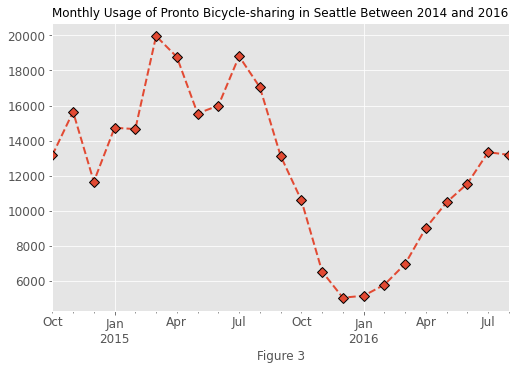

In [16]:
# Monthly Usage of Pronto Bicycle-sharing in Seattle Between 2014 and 2016
plt.subplots(figsize=(18,18))
ax_3 = plt.subplot2grid((3,2),(0,0))
p1['year_month']=p1.date.astype('datetime64[M]')
df_3=p1.groupby('year_month').sum()['count']
df_3.plot(linestyle='dashed',marker='D',ax=ax_3,fontsize=12,linewidth=2,markeredgecolor='black',markersize=7)
ax_3.set_title('Monthly Usage of Pronto Bicycle-sharing in Seattle Between 2014 and 2016',fontsize=12)
ax_3.set_xlabel('Figure 3',fontsize=12);

Figure 4 shows the hourly usage of Pronto Bicycle-sharing group by week in Seattle between 2014 and 2016.

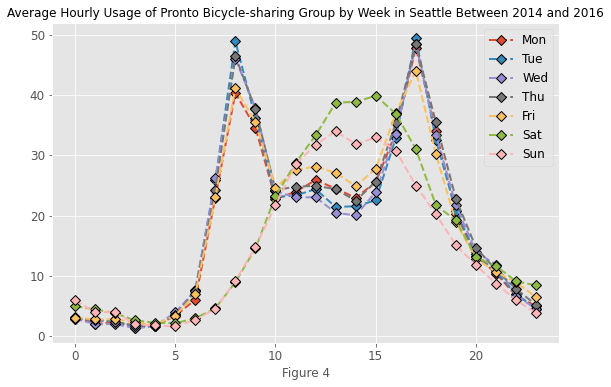

In [17]:
# Hourly Usage of Pronto Bicycle-sharing Group by Week in Seattle Between 2014 and 2016
plt.subplots(figsize=(20,20))
ax_4=plt.subplot2grid((3,2),(1,0))
df_4=p1.groupby(['hour','weekday']).mean().unstack()['count']
df_4.rename(columns={0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'},inplace=True)
df_4.plot(linestyle='dashed',marker='D',ax=ax_4,fontsize=12,linewidth=2,markeredgecolor='black',markersize=7)
ax_4.set_title('Average Hourly Usage of Pronto Bicycle-sharing Group by Week in Seattle Between 2014 and 2016',fontsize=12)
plt.legend(loc='upper right',fontsize=12)
ax_4.set_xlabel('Figure 4',fontsize=12);

#### Conclusion:

In Figure 3, we found that the usage of bicycle-sharing system was the highest in April 2015, followed by July, and the least was in January 2016. We also found that the usage in 2016 was lower than in the same period in 2015, which may be caused by several factors, such as more competitors, low user satisfaction, single publicity channels, and so on.

In Figure 4, we can see that the usage on weekdays is almost the same, with peak periods at 8 a.m. and 17 p.m.which shows that most of the purpose of renting is to commute to work. The demand on weekends is lower than on weekdays, and the peak period is 1-3 p.m. which indicates that many people do some recreation after lunch.


### 3. Weather 


Let's merge the weather dataset with the p1 dataset above.

In [18]:
# Merging the datasets
df2=p1.merge(right=weather,how='inner',left_on='date',right_on='Date')
df2=df2.drop(['date','year_month'],axis=1)
df2.head()

,year,month,day,hour,weekday,count,Date,temperature,humidity,visibility_miles,wind_speed,precipitation
0,2014,10,13,10,0,12,2014-10-13,62.0,68,10,4,0.0
1,2014,10,13,11,0,108,2014-10-13,62.0,68,10,4,0.0
2,2014,10,13,12,0,84,2014-10-13,62.0,68,10,4,0.0
3,2014,10,13,13,0,78,2014-10-13,62.0,68,10,4,0.0
4,2014,10,13,14,0,112,2014-10-13,62.0,68,10,4,0.0


The first plot shows the usage of Pronto Bicycle-sharing by different temperature in Seattle between 2014 and 2016.

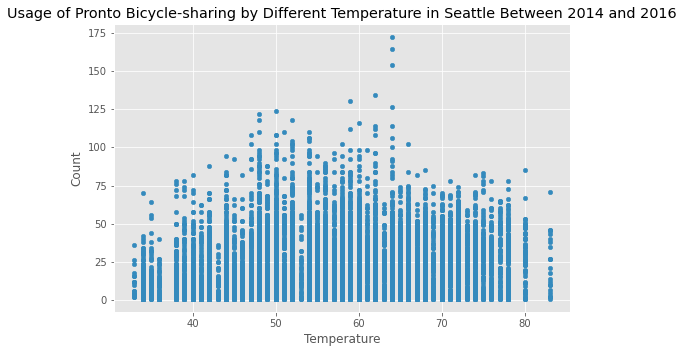

In [19]:
# Usage of Pronto Bicycle-sharing by Different Temperature in Seattle Between 2014 and 2016
fig=plt.subplots(figsize=(18,18))
ax_1=plt.subplot2grid((3,2),(0,0))
df2.plot.scatter(x='temperature',y='count',ax=ax_1)
ax_1.set_title('Usage of Pronto Bicycle-sharing by Different Temperature in Seattle Between 2014 and 2016')
ax_1.set_xlabel('Temperature')
ax_1.set_ylabel('Count');

The second plot shows the usage of Pronto Bicycle-sharing by different humidity in Seattle between 2014 and 2016.

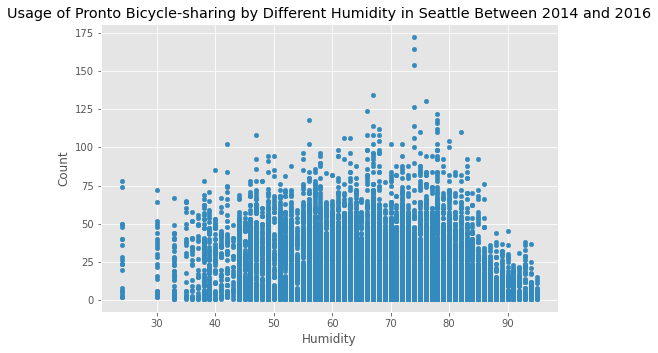

In [20]:
# Usage of Pronto Bicycle-sharing by Different Humidity in Seattle Between 2014 and 2016
fig=plt.subplots(figsize=(18,18))
ax_2=plt.subplot2grid((3,2),(0,0))
df2.plot.scatter(x='humidity',y='count',ax=ax_2)
ax_2.set_title('Usage of Pronto Bicycle-sharing by Different Humidity in Seattle Between 2014 and 2016')
ax_2.set_xlabel('Humidity')
ax_2.set_ylabel('Count');

The third plot shows the usage of Pronto Bicycle-sharing by different visibility miles in Seattle between 2014 and 2016.

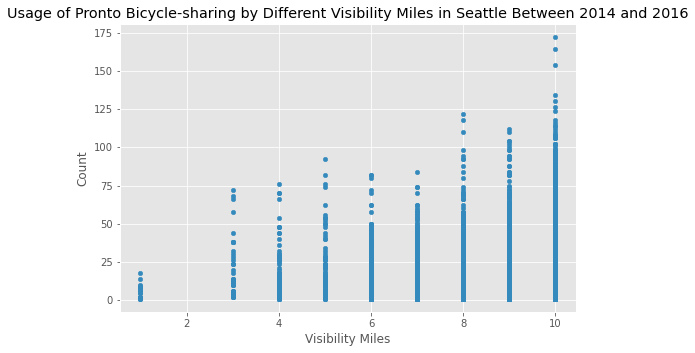

In [21]:
# Usage of Pronto Bicycle-sharing by Different Visibility Miles in Seattle Between 2014 and 2016
fig=plt.subplots(figsize=(18,18))
ax_3=plt.subplot2grid((3,2),(0,0))
df2.plot.scatter(x='visibility_miles',y='count',ax=ax_3)
ax_3.set_title('Usage of Pronto Bicycle-sharing by Different Visibility Miles in Seattle Between 2014 and 2016')
ax_3.set_xlabel('Visibility Miles')
ax_3.set_ylabel('Count');

The fourth plot shows the usage of Pronto Bicycle-sharing by different wind speed in Seattle between 2014 and 2016.

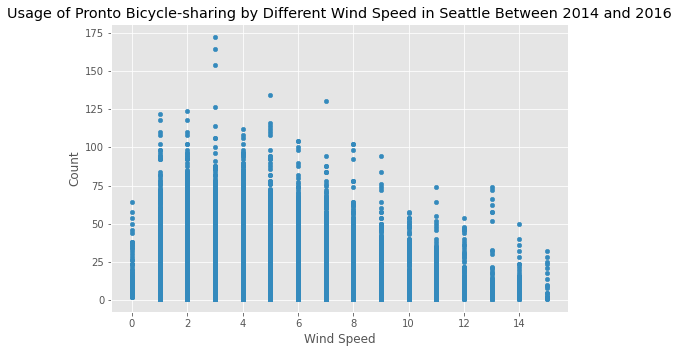

In [22]:
# Usage of Pronto Bicycle-sharing by Different Wind Speed in Seattle Between 2014 and 2016
fig=plt.subplots(figsize=(18,18))
ax_4=plt.subplot2grid((3,2),(0,0))
df2.query('wind_speed<20').plot.scatter(x='wind_speed',y='count',ax=ax_4)
ax_4.set_title('Usage of Pronto Bicycle-sharing by Different Wind Speed in Seattle Between 2014 and 2016')
ax_4.set_xlabel('Wind Speed')
ax_4.set_ylabel('Count');

The last one shows the usage of Pronto Bicycle-sharing by different precipitation in Seattle between 2014 and 2016.

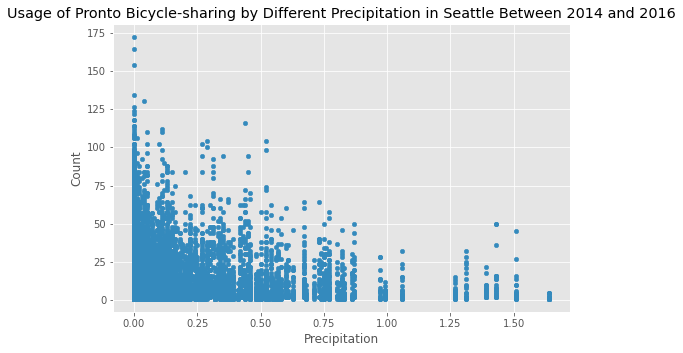

In [23]:
# Usage of Pronto Bicycle-sharing by Different Precipitation in Seattle Between 2014 and 2016
fig=plt.subplots(figsize=(18,18))
ax_5=plt.subplot2grid((3,2),(0,0))
df2.query('precipitation<2').plot.scatter(x='precipitation',y='count',ax=ax_5)
ax_5.set_title('Usage of Pronto Bicycle-sharing by Different Precipitation in Seattle Between 2014 and 2016')
ax_5.set_xlabel('Precipitation')
ax_5.set_ylabel('Count');

#### Conclusion:

According to these plots, we found the following:

The usage of the bicycle-sharing system is high when the temperature in the range of 40-80 degrees Fahrenheit, and too high or too low temperature inhibits the demand for renting.

The usage of the bicycle-sharing system is high when the humidity in the range of 40-80, and too high or too low humidity inhibits the demand for renting.

The higher the visibility, the higher the usage of the bicycle-sharing system.

The higher the wind speed, the lower the usage of the bicycle-sharing system.

The lower the precipitation, the higher the usage of the bicycle-sharing system.


### Visualize Correlation Matrix

Finally, let's plot a correlation matrix to summarize data.


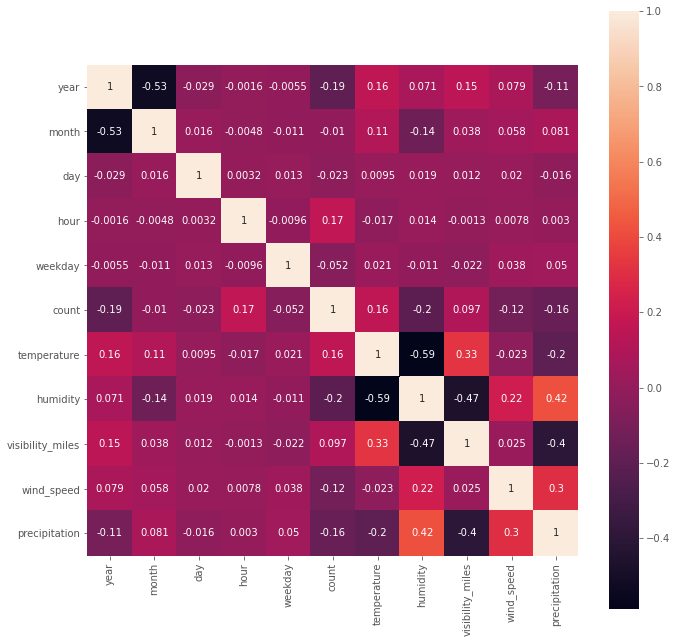

In [24]:
import seaborn as sb
cr=df2.corr()
cr
fig=plt.figure(figsize=(11,11))
sb.heatmap(cr,annot=True,square=True);

In [25]:
# Ranking of correlation coefficients 
cr.sort_values('count',ascending=False)['count']

count               1.000000
hour                0.167643
temperature         0.156471
visibility_miles    0.096871
month              -0.010106
day                -0.023352
weekday            -0.051828
wind_speed         -0.122263
precipitation      -0.160510
year               -0.192584
humidity           -0.203989
Name: count, dtype: float64

#### Conclusion:

According to the output, we found that hour and temperature have the most positive correlation with bicycle sharing system usage. In contrast, humidity and year have the most negative correlation with bicycle sharing system usage. 

### Summary

In this project, we found that the operation of the bicycle sharing system is affected by many factors. Based on the analysis, the company can develop better strategies to make profits. For example, the company can develop a strategy to increase service staff during peak periods and increase the supply of bicycles in summer which helps improve bicycle utilization. The company can also send coupons through emails or advertisements to attract more customers. 

I believe that data analysis can play an important role in more areas in the future. Thank you so much for watching!